In [85]:
#🔤 EMNIST Character Recognition
#Project Title: "EMNIST Letter Recognition"
#Goal: Extend the digit classifier to recognize uppercase/lowercase letters (balanced split of EMNIST).
#Challenge: Preprocess EMNIST correctly (since it needs rotation) and handle more classes.


In [86]:
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 
from torch.utils.data import TensorDataset,DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score
from PIL import Image


In [87]:
import torchvision
print(torchvision.__version__)

0.22.1+cpu


In [88]:
from torchvision import datasets,transforms
emnist_transform = transforms.Compose([
    transforms.Lambda(lambda img: img.rotate(-90, expand=True).transpose(Image.FLIP_LEFT_RIGHT)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_data=datasets.EMNIST(root='./data',split='balanced',train=True,download=True,transform=emnist_transform)
test_data=datasets.EMNIST(root='./data',split='balanced',train=False,download=True,transform=emnist_transform)

In [89]:
train_loader=DataLoader(train_data,batch_size=64,shuffle=True)
test_loader=DataLoader(test_data,batch_size=64,shuffle=True)

In [93]:
class CharacterRecognition(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3,padding=1)
        self.conv2=nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)


        self.fc1=nn.Linear(128*3*3,128)
        self.fc2=nn.Linear(128,47)
    def forward(self,X):
        X=F.relu(self.conv1(X))
        X=F.max_pool2d(X,2,2)

        X=F.relu(self.conv2(X))
        X=F.max_pool2d(X,2,2)

        X=F.relu(self.conv3(X))
        X=F.max_pool2d(X,2,2)

        X=X.view(X.size(0),-1)

        X=self.fc1(X)
        X=self.fc2(X)

        return X
        

In [94]:
model=CharacterRecognition()
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)

In [95]:
epochs=10
model.train()
for epoch in range(epochs):
    running_loss=0
    for inputs,labels in train_loader:
        outputs=model(inputs)
        loss=criterion(outputs,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
    average_loss=running_loss/len(train_loader)
    print(f"epoch {epoch+1},loss :{average_loss}")

epoch 1,loss :0.5854496888296549
epoch 2,loss :0.3617048833605855
epoch 3,loss :0.3245919472662076
epoch 4,loss :0.2971625297044531
epoch 5,loss :0.2762454671069971
epoch 6,loss :0.2591725138422277
epoch 7,loss :0.24050773218933386
epoch 8,loss :0.2265728876560977
epoch 9,loss :0.21316530012012677
epoch 10,loss :0.20117625674012027


accuracy: 0.8767021276595744


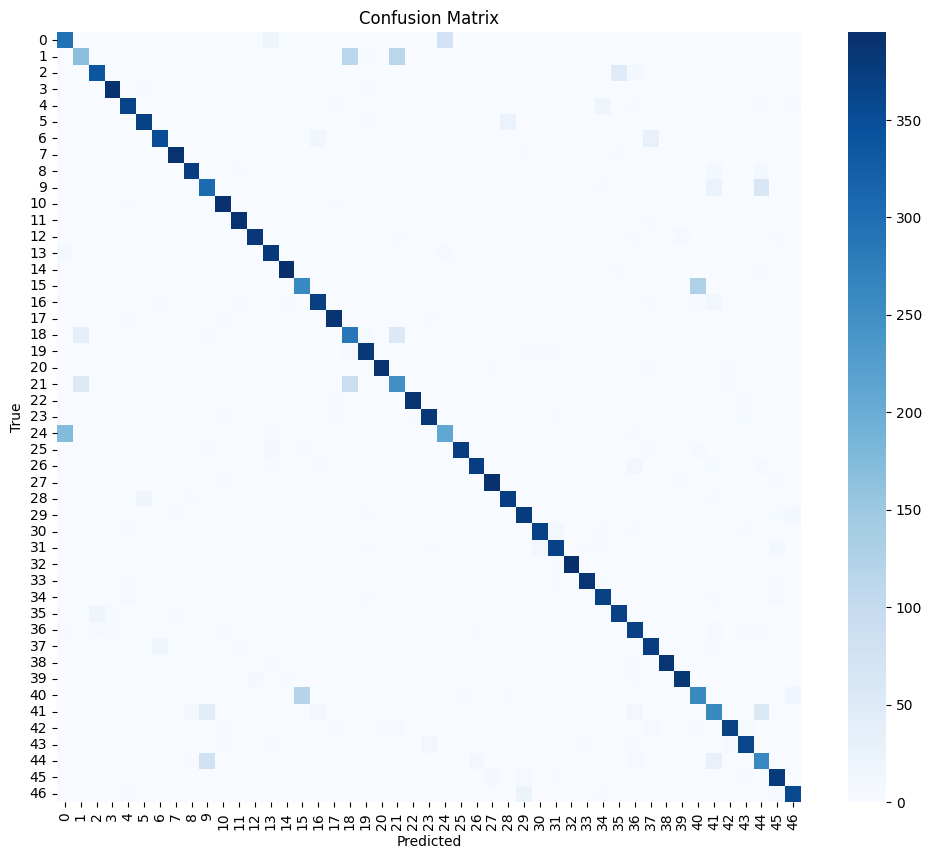

In [96]:
model.eval()
all_labels=[]
all_preds=[]
with torch.no_grad():
    for inputs,labels in test_loader:
        outputs=model(inputs)
        preds=torch.argmax(outputs,dim=1)

        all_labels.extend(labels.numpy())
        all_preds.extend(preds.numpy())
accuracy=accuracy_score(all_labels,all_preds)
print("accuracy:",accuracy)

from sklearn.metrics import confusion_matrix, classification_report
#print(classification_report(all_labels, all_preds))
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


